## Search for a job Description

The main motivations for this project were three-fold. Firstly, we aimed to explore and apply novel models in the field of Natural Language Processing (NLP), such as OpenAI embedding and MPNet from Hugging Face. Secondly, we sought to develop an application that is specifically tailored for job search. Upon inputting a job title, users would be able to obtain a list of the closest task descriptions associated with that particular job title. Lastly, we aimed to experiment with two different methods of deploying our application - Github pages and Streamlit app.

The inspiration for this project came from a personal experience, where one of our team members received a suggestion from an employer to consider coordinator positions that were suitable for her resume and skills. However, she had never considered or looked for such positions before. This sparked the idea of developing an application that would be beneficial not only to her, but also to the thousands of people who are starting their career and looking for job opportunities.

Furthermore, we were inspired by a lecture by Professor Ran Feldish, where he presented an application that uses OpenAI embedding to match products with product descriptions (https://github.com/ShawnTXin/openai-embeddings). This motivated us to use a similar approach, but with a different objective - matching job titles with job descriptions.

The dataset used in this project was obtained from ONET Resource Center (https://www.onetcenter.org/), specifically the Task Statements Database, which provides a mapping of ONET-SOC codes (occupations) to tasks associated with the occupation.

In this notebook, we will first explore OpenAI embedding and then experiment with MPNet sentence transformer.

# Streamlit application:

##### We made an application for MPNet model.it asks the user for job title and gives them top five job tasks for the inserted job title. There were some limitations in this step. Since we wanted our model to be fast and don’t calculate the embeddings for each job task from the scratch, we used the dataset with the column embedding for each task which was calculated during the project. And the dataset was more than 300 MB so we couldn’t upload it in github so we used a sliced dataset for our application.
##### There are many ways for improvement specially in graphics of the application.We are planning to add a new feature and combine the two methods into one app and ask the user to choose the model they want and then insert the desired job title to get the tasks.
##### The link to application is:
https://saharhekmatdoust-math-dl-project1-mpnet-streamlit-app-2dbyrk.streamlit.app/


## Github Pages:
#### upon creating github pages, we had some errors and we thought maybe it has something to do with google colab notebooks.
#### So We Created github pages only for the first model which wasn't originally made by google colab.here is the link to our github pages:
https://saharhekmatdoust.github.io/math-dl-project1/Example.html

## First Model: OpenAI "text-embedding-ada-002"

To provide proper attribution, we would like to acknowledge that approximately 90% of the implementation of this model was adapted from "https://github.com/ShawnTXin/openai-embeddings". However, we utilized the code with our OpenAI API and applied it to a novel dataset for our project.

### 1- Import the libraries

In [29]:
!pip install utils openai tiktoken
import os
import time
import numpy as np
import pandas as pd

from openai.embeddings_utils import get_embedding
from openai.embeddings_utils import cosine_similarity
import tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.3 MB/s eta 0:00:00


In [30]:
import openai

#OpenAI API Key location
ENV_PATH = "/content/env"

def get_openai_api_key(env_path=ENV_PATH):
    # read and parse file
    with open(env_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        if line.startswith("OPENAI_API_KEY"):
            openai_api_key = line.split("=")[1].strip()
        else:
            print("Error")
    print(f'Read OpenAI API authentication key from {env_path} file')
    return openai_api_key

def openai_auth(openai_api_key:str=get_openai_api_key()):
    # authenticate with OpenAI
    openai.api_key = openai_api_key
    print(f'Set OpenAI authentication key')
    return

Read OpenAI API authentication key from /content/env file


### 2- Defining the Dataset and Model

In this section, we define the input file containing the tasks for which we want to generate embeddings and the output path where we would like to save these embeddings. We also define the models that will be used for encoding and embedding.

For the input data, we have specified the location of the CSV file containing the tasks we want to embed and the column name of the task description. We will use this column to generate embeddings.

The output data parameters define where we want to save the embeddings generated by the embedding model.

For the embedding model, we have specified the name of the pre-trained model to use and the encoding model to be used in conjunction with it. We have also set an upper limit on the number of tokens to be utilized in each input sequence. This limit is in accordance with the guidelines presented in "https://platform.openai.com/docs/guides/embeddings/what-are-embeddings".

In [31]:
# input data parameters
DOCUMENT_PATH = "/content/Task Statements(1).xlsx"
COLUMN_TO_EMBED = "Task"

# output data parameters
OUTPUT_PATH = "/content/drive/MyDrive/TaskEmbeddings_boshra.csv"

#embedding model parameters
EMBEDDING_MODEL = "text-embedding-ada-002"
ENCODING_MODEL = "cl100k_base"  # this is the encoding for text-embedding-ada-002
MAX_TOKENS = 8191  # the maximum for text-embedding-ada-oo2 is 8191

print(f'Using embedding model: {EMBEDDING_MODEL}')
print(f'Using encoding: {ENCODING_MODEL}')
print(f'Maximum number of tokens: {MAX_TOKENS}')
print('***********************************')
df = pd.read_excel(DOCUMENT_PATH)
print(f'Read {len(df)} documents from {DOCUMENT_PATH}')
#Print samples from the dataset
df.head(10)

Using embedding model: text-embedding-ada-002
Using encoding: cl100k_base
Maximum number of tokens: 8191
***********************************
Read 19265 documents from /content/Task Statements(1).xlsx


,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,87.0,07/2014,Incumbent
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assig...,Core,87.0,07/2014,Incumbent
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,87.0,07/2014,Incumbent
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,87.0,07/2014,Incumbent
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,87.0,07/2014,Incumbent
5,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,87.0,07/2014,Incumbent
6,11-1011.00,Chief Executives,8836,Implement corrective action plans to solve org...,Core,87.0,07/2014,Incumbent
7,11-1011.00,Chief Executives,8832,"Direct human resources activities, including t...",Core,86.0,07/2014,Incumbent
8,11-1011.00,Chief Executives,8835,Establish departmental responsibilities and co...,Core,86.0,07/2014,Incumbent
9,11-1011.00,Chief Executives,8833,"Preside over, or serve on, boards of directors...",Core,87.0,07/2014,Incumbent


In [33]:
#Print the samples from the 'Task' column that will be used to generate embeddings
print(df['Title'].values[0],"Tasks")
print(df['Task'].values[:3])
df[['Task']].head()

Chief Executives Tasks
["Direct or coordinate an organization's financial or budget activities to fund operations, maximize investments, or increase efficiency."
 'Appoint department heads or managers and assign or delegate responsibilities to them.'
 'Analyze operations to evaluate performance of a company or its staff in meeting objectives or to determine areas of potential cost reduction, program improvement, or policy change.']


,Task
0,Direct or coordinate an organization's financi...
1,Appoint department heads or managers and assig...
2,Analyze operations to evaluate performance of ...
3,"Direct, plan, or implement policies, objective..."
4,"Prepare budgets for approval, including those ..."


### 3- Generate Encodings
In this section, we utilize the encoding model that is associated with the embedding model "text-embedding-ada-002". Encoding is performed to ensure two benefits. Firstly, it confirms that the number of tokens is less than the maximum tokens that the embedding model accepts. Secondly, it provides an estimate of the pricing when using the embedding model since usage is priced per input token.

We added the encoding of the "task" column to the original data and ensured that there were no encodings that exceed the maximum token limit set by the embedding model. This step is important as it prevents any loss of data during the subsequent steps of the project.

In [35]:
# tokenize: generate encodings for 'cloumn_to_embed'
encoding = tiktoken.get_encoding(ENCODING_MODEL)
df["encoding"] = df[COLUMN_TO_EMBED].apply(lambda x: encoding.encode(x))
print(f'Encoded the {COLUMN_TO_EMBED} column into an encoding column')
df.head()

Encoded the Task column into an encoding column


,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,encoding
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,87.0,07/2014,Incumbent,"[16411, 477, 16580, 459, 7471, 596, 6020, 477,..."
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assig...,Core,87.0,07/2014,Incumbent,"[2213, 787, 9476, 14971, 477, 20258, 323, 9993..."
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,87.0,07/2014,Incumbent,"[2127, 56956, 7677, 311, 15806, 5178, 315, 264..."
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,87.0,07/2014,Incumbent,"[16411, 11, 3197, 11, 477, 4305, 10396, 11, 26..."
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,87.0,07/2014,Incumbent,"[51690, 42484, 369, 14765, 11, 2737, 1884, 369..."


In [36]:
# omit encodings that are too long to embed
df["n_tokens"] = df.encoding.apply(lambda x: len(x))
n_long_encodings = len(df[df.n_tokens > MAX_TOKENS])
df = df[df.n_tokens <= MAX_TOKENS]
print(f'Omitted {n_long_encodings} encodings that were too long to embed')

Omitted 0 encodings that were too long to embed


### 4- Generate Embeddings

In this section, we focus on the core building block of our project, which is the embedding model. Based on the recommendation from OpenAI, we used the "text-embedding-ada-002" model for nearly all use cases, and we found it to be better, cheaper, and simpler to use. However, we did encounter some issues with the computation time, which could be attributed to the size of our dataset (19265 sentences) and the computing power of our device. To validate this, we tested the model on a smaller sample size of 1000 sentences, and it was much faster.

It's important to note that in order to use the embedding model from OpenAI, we had to obtain an OpenAI API key, which needed to be checked and authorized. Once the API key was validated, we were able to use the embedding model accurately and without any errors.

Additionally, we want to emphasize that we did not pay to use the embedding model. We obtained the OpenAI API key from the official website (https://platform.openai.com/account/api-keys), but it required creating an account to get the API key.

To better understand how the embedding model works, we need to understand what embeddings are. Embeddings are numerical representations of text where the text is used as input to the model, and the model generates a numerical vector that corresponds to the input text. The model takes into consideration the context, relationships between words, parts of speech, and other factors to generate the numbers. Embeddings that are numerically similar are also semantically similar, which is why they are useful for natural language processing tasks.

In summary, we used the recommended OpenAI embedding model, obtained an OpenAI API key, and generated numerical representations of text using the model.


![openAI Embedding](https://cdn.openai.com/embeddings/draft-20220124e/vectors-3.svg)


In [ ]:
openai_auth()

# embed: generate embeddings for 'column_to_embed', by calling the OpenAI API
print(f'Embedded {COLUMN_TO_EMBED} into an embedding column, by calling the OpenAI API')
print(f'This will take some time for {len(df)} documents...')
df["embedding"] = df[COLUMN_TO_EMBED].apply(lambda x: get_embedding(x, engine=EMBEDDING_MODEL))

Set OpenAI authentication key
Embedded Task into an embedding column, by calling the OpenAI API
This may take about a minute for 19265 documents...


In [ ]:
# save embeddings to output_path
df.to_csv(OUTPUT_PATH, index=False)
print(f'Saved embeddings to {OUTPUT_PATH}')

Saved embeddings to data/TaskEmbeddingss.csv


In [41]:
file_path = "/content/drive/MyDrive/TaskEmbeddings_boshra.csv"  # a folder with all the documents embeddings. within this folder, one csv file include multiple documents embedding of the same run
COLUMN_EMBEDDINGS = "embedding"  # the embedding column name in the documents embedding file.

In [42]:
# read documents embeddings
df = pd.read_csv(file_path)
df[COLUMN_EMBEDDINGS] = df[COLUMN_EMBEDDINGS].apply(eval).apply(np.array) # convert string to np array
print(f'Read {len(df)} documents embeddings from {file_path}')



Read 19265 documents embeddings from /content/drive/MyDrive/TaskEmbeddings_boshra.csv


### 5- Testing the model

#### First example: Nurse




In [49]:
openai_auth()
query=""
print('***********************************')
query = "Nurse" 
tic = time.time()
query_embedding = get_embedding(query, engine=EMBEDDING_MODEL)
toc = time.time()
print(f'Embedding {query} took {round(toc-tic)*1000}ms')
print(f'Top matches for {query} ordered by cosine similarity of vector embeddings:')
df['similarity'] = df[COLUMN_EMBEDDINGS].apply(lambda x: cosine_similarity(x, query_embedding))
#print(df.sort_values(by='similarity', ascending=False)[['Title','Task','similarity' ]].head(10))
df.sort_values(by='similarity', ascending=False)[['Title','Task','similarity' ]].head(10)


Set OpenAI authentication key
***********************************
Embedding Nurse took 1000ms
Top matches for Nurse ordered by cosine similarity of vector embeddings:


,Title,Task,similarity
9294,Urologists,"Direct the work of nurses, residents, or other...",0.866371
8807,Registered Nurses,Observe nurses and visit patients to ensure pr...,0.864399
10218,Psychiatric Aides,"Perform nursing duties, such as administering ...",0.863363
8650,Respiratory Therapists,"Work as part of a team of physicians, nurses, ...",0.862016
8975,Nurse Midwives,"Plan, provide, or evaluate educational program...",0.861606
9859,Licensed Practical and Licensed Vocational Nurses,Supervise nurses' aides or assistants.,0.861478
8891,Critical Care Nurses,Supervise and monitor unit nursing staff.,0.859506
9041,Anesthesiologists,"Coordinate and direct work of nurses, medical ...",0.858469
10170,Nursing Assistants,Assist nurses or physicians in the operation o...,0.858173
9278,Hospitalists,"Direct, coordinate, or supervise the patient c...",0.857854


#### Second example: Data Scientist


In [48]:
openai_auth()
query=""
print('***********************************')
query = "Data Scientist"
tic = time.time()
query_embedding = get_embedding(query, engine=EMBEDDING_MODEL)
toc = time.time()
print(f'Embedding {query} took {round(toc-tic)*1000}ms')
print(f'Top matches for {query} ordered by cosine similarity of vector embeddings:')
df['similarity'] = df[COLUMN_EMBEDDINGS].apply(lambda x: cosine_similarity(x, query_embedding))
#print(df.sort_values(by='similarity', ascending=False)[['Title','Task','similarity' ]].head(10))
df.sort_values(by='similarity', ascending=False)[['Title','Task','similarity' ]].head(10)


Set OpenAI authentication key
***********************************
Embedding Data Scientist took 0ms
Top matches for Data Scientist ordered by cosine similarity of vector embeddings:


,Title,Task,similarity
2997,Bioinformatics Technicians,Develop or apply data mining and machine learn...,0.869527
2917,Biostatisticians,Develop or implement data analysis algorithms.,0.864632
2932,Data Scientists,"Analyze, manipulate, or process large sets of ...",0.863898
5338,Social Science Research Assistants,Design and create special programs for tasks s...,0.852801
5341,Social Science Research Assistants,Perform descriptive and multivariate statistic...,0.851475
2905,Statisticians,Develop software applications or programming f...,0.849103
2951,Business Intelligence Analysts,"Create business intelligence tools or systems,...",0.846382
2895,Statisticians,Process large amounts of data for statistical ...,0.846101
2986,Bioinformatics Technicians,Analyze or manipulate bioinformatics data usin...,0.845648
2991,Bioinformatics Technicians,Develop or maintain applications that process ...,0.845227


#### Third Example: Ask the user for a job title

In [60]:
openai_auth()
query=""
print('***********************************')
query = input('Please enter a Job Title: ') # get query from user
tic = time.time()
query_embedding = get_embedding(query, engine=EMBEDDING_MODEL)
toc = time.time()
print(f'Embedding query took {round(toc-tic)*1000}ms')
print(f'Top matches for {query} ordered by cosine similarity of vector embeddings:')
df['similarity'] = df[COLUMN_EMBEDDINGS].apply(lambda x: cosine_similarity(x, query_embedding))
#print(df.sort_values(by='similarity', ascending=False)[['Title','Task','similarity' ]].head(10))
df.sort_values(by='similarity', ascending=False)[['Title','Task','similarity' ]].head(10)

Set OpenAI authentication key
***********************************
Please enter a Job Title: Mechanical Engineer
Embedding query took 1000ms
Top matches for Mechanical Engineer ordered by cosine similarity of vector embeddings:


,Title,Task,similarity
4017,Electro-Mechanical and Mechatronics Technologi...,Assist engineers to implement electromechanica...,0.882823
4127,Mechanical Engineering Technologists and Techn...,Provide technical support to other employees r...,0.873477
4150,Mechanical Engineering Technologists and Techn...,"Devise, fabricate, or assemble new or modified...",0.873453
18767,Sailors and Marine Oilers,Provide engineers with assistance in repairing...,0.872678
4014,Electro-Mechanical and Mechatronics Technologi...,Translate electromechanical drawings into desi...,0.872547
15885,"Maintenance and Repair Workers, General",Design new equipment to aid in the repair or m...,0.872355
3542,Mechanical Engineers,"Research, design, evaluate, install, operate, ...",0.872036
4018,Electro-Mechanical and Mechatronics Technologi...,Consult with machinists to ensure that electro...,0.870969
3997,Electro-Mechanical and Mechatronics Technologi...,"Fabricate or assemble mechanical, electrical, ...",0.870386
16035,"Helpers--Installation, Maintenance, and Repair...","Design, weld, and fabricate parts, using bluep...",0.869464


# Second Model: Using Transformers, MPNet from Hugging Face

### As mentioned before, 
The project is about a targeted and accurate search for job responsibilities based on job title. It can be particularly useful for job seekers who want to understand the day-to-day responsibilities of a particular job and improve their abilities and knowledge, or for employers who want to compare the job responsibilities of different positions. We use transformer models and cosine similarity that allows for a more nuanced understanding of the meaning and context of the text.



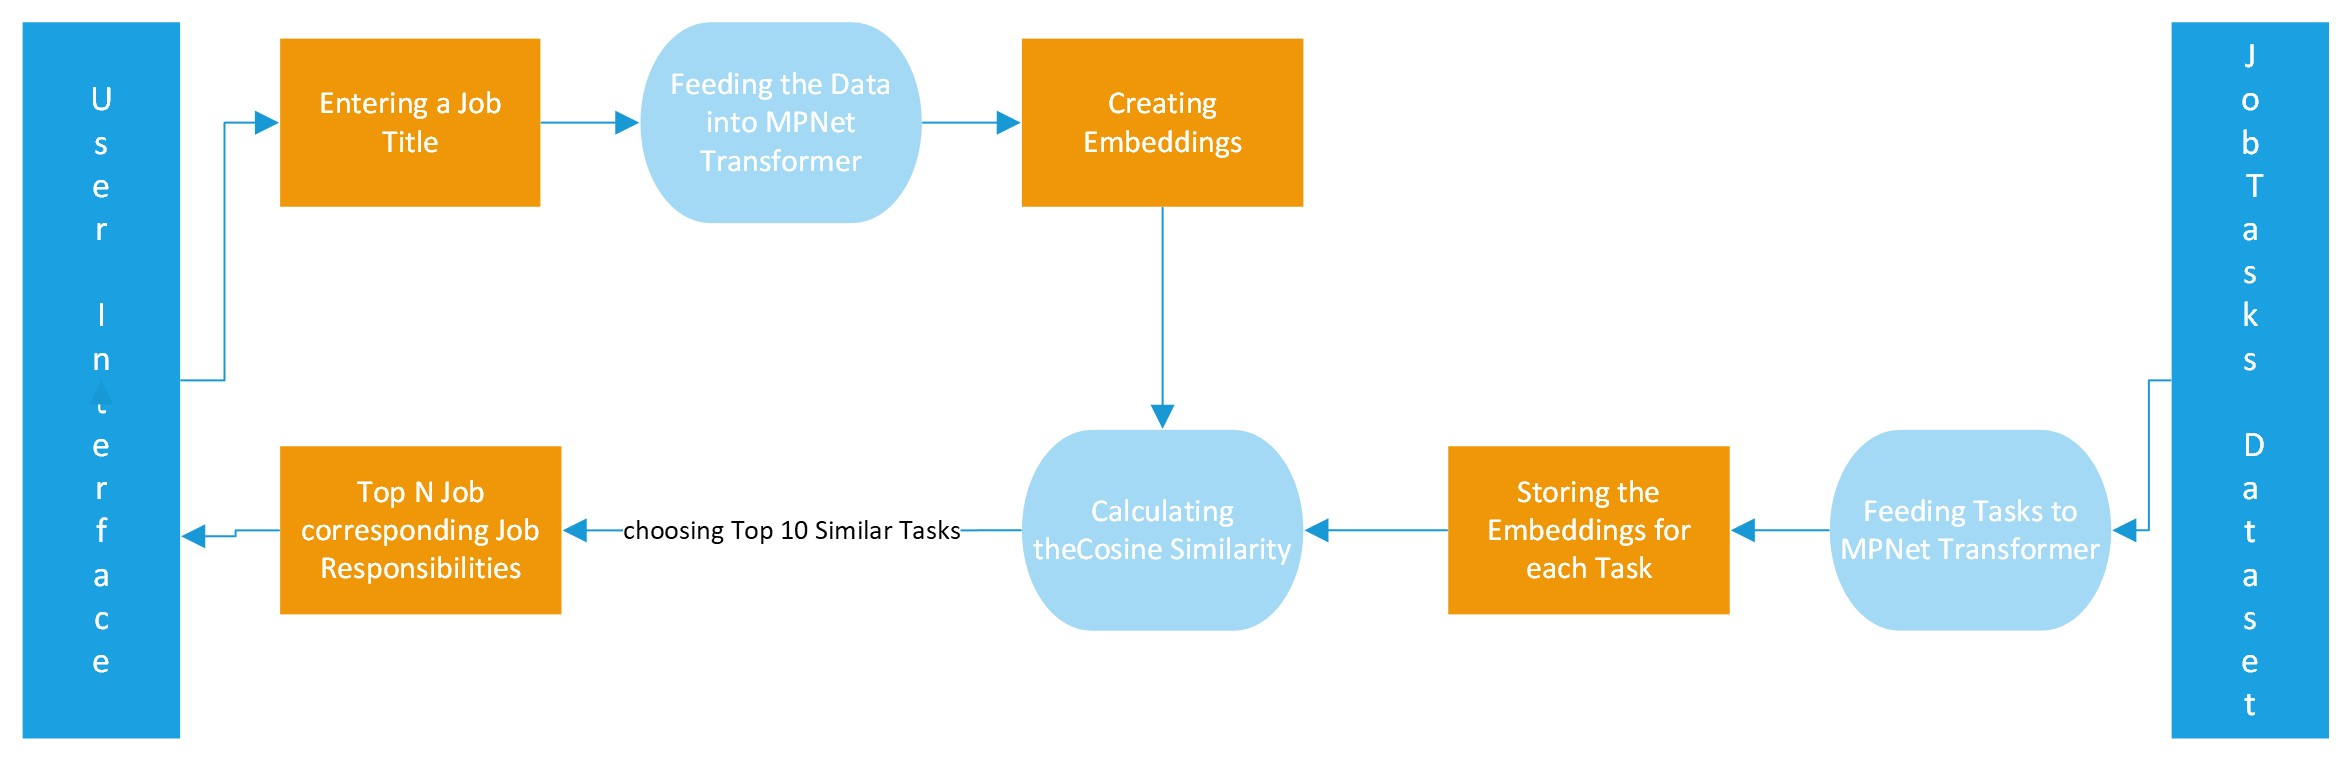

###The transformer converts each job task from dataset into an embedding vector of size 768 and stores it. When the user inserts a job title, our search engine quickly converts the job title to a vector and then calculates the cosine similarity between the stores job responsibilities and inserted job title and gives the top n responsibilities related to the job title.

### We used all-mpnet-base-v2 from hugging face.
#### https://huggingface.co/sentence-transformers/all-mpnet-base-v2
###This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search. Input text longer than 384 word pieces is truncated

### a simple example code for how to use this transformer is as below: 


```
from sentence_transformers import SentenceTransformer

sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

embeddings = model.encode(sentences)

print(embeddings)
```



###The transformer is based on   microsoft/mpnet-base model but fine-tuned using 215M question-answer pairs from various sources and domains, including StackExchange, Yahoo Answers, Google & Bing search queries and many more. These model perform well across many search tasks and domains.
https://www.sbert.net/docs/pretrained_models.html

#The reason why we chose MPNet:
####based on the article "MPNet: Masked and Permuted Pre-training for Language Understanding" MPNet combines strengths of masked and permuted language modeling for language understanding.
####Masked language modeling (MLM) is proposed in BERT, which randomly masks some tokens with a masked symbol [M] and predicts the masked tokens given remaining tokens.
####Permuted language modeling (PLM) is proposed in XLNet, which randomly permutes a sequence and predicts the tokens in the right part (predicted part) in an autoregressive way. 
#### Comparing MLM and PLM, we can find their advantages and disadvantages: 
####1) MLM can see the position information of the full sentence, but cannot model the dependency among the predicted tokens, which cannot learn the complicated semantic relationships well
####2) PLM can model the dependency among the predicted tokens with autoregressive prediction, but it cannot see the position information of the full sentence, which will cause mismatches between the pretraining and fine-tuning since the position information of the full sentence can be seen in the downstream tasks.
####MPNet Combines the best of both worlds
[https://www.microsoft.com/en-us/research/blog/mpnet-combines-strengths-of-masked-and-permuted-language-modeling-for-language-understanding/](https://)








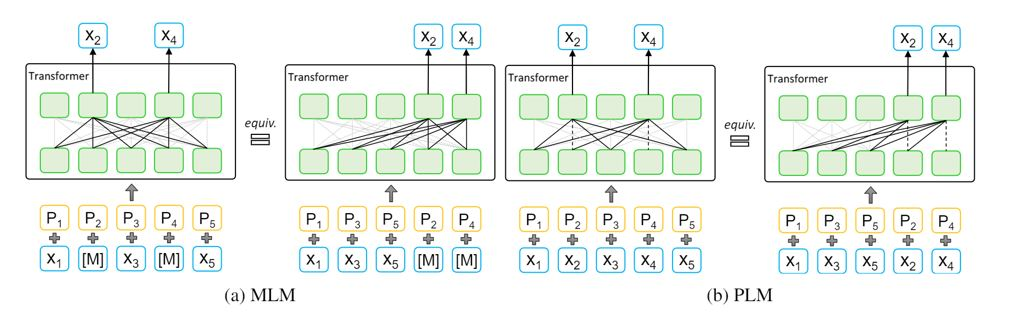

In [1]:
import pandas as pd
import torch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install sentence_transformers transformers
from sentence_transformers import SentenceTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 111.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=1765576355032b74d0974113745001a76a057a85c639a36379c310c58bc15ae9
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers


### Importing the datset and see the overview of it.

In [4]:
job_data=pd.read_excel("/content/Task Statements(1).xlsx")
job_data.head()

,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,87.0,07/2014,Incumbent
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assig...,Core,87.0,07/2014,Incumbent
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,87.0,07/2014,Incumbent
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,87.0,07/2014,Incumbent
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,87.0,07/2014,Incumbent


### We will only use "Task" column for creating embeddings.

In [5]:
job=job_data[['Title','Task','Task Type']]
job.head()

,Title,Task,Task Type
0,Chief Executives,Direct or coordinate an organization's financi...,Core
1,Chief Executives,Appoint department heads or managers and assig...,Core
2,Chief Executives,Analyze operations to evaluate performance of ...,Core
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core
4,Chief Executives,"Prepare budgets for approval, including those ...",Core


In [ ]:
job.shape

(19265, 3)

### Feeding Task column into our Transformer and making embeddings of each row:

In [6]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [7]:
embeddings = model.encode(job.Task.to_list(), show_progress_bar=True)

Batches:   0%|          | 0/603 [00:00<?, ?it/s]

In [ ]:
embeddings

array([[ 0.00111516, -0.01212562,  0.00674503, ..., -0.0020985 ,
         0.00597191,  0.00498586],
       [ 0.05327297,  0.03539166, -0.01899687, ...,  0.01133153,
         0.01639626, -0.00217442],
       [-0.04514263,  0.03885555,  0.00111902, ...,  0.00812996,
         0.01865058,  0.00662476],
       ...,
       [-0.027717  , -0.05803878, -0.00317996, ...,  0.00536576,
        -0.05789692, -0.00941571],
       [-0.01636929,  0.00543327,  0.00593052, ..., -0.02465145,
        -0.06171609, -0.03174858],
       [-0.02750921,  0.02371879, -0.02141186, ..., -0.03028779,
        -0.02668517, -0.02936578]], dtype=float32)

In [ ]:
print(len(embeddings[0]),len(embeddings))

768 19265


### Cosine Similarity Function for determining similarity:

In [8]:
def cosine_similarity(a,b):
    dot_product = np.dot(a, b)

    # compute magnitudes
    magnitude_a = np.sqrt(np.dot(a, a))
    magnitude_b = np.sqrt(np.dot(b, b))

    # compute cosine similarity
    cos_sim = dot_product / (magnitude_a * magnitude_b)
    return cos_sim

## Inserting an example Job title to see the relative Job responsibilities:
first we convert it to vector embedding:

In [9]:
example_job_title=np.array(model.encode("Nurse", show_progress_bar=True))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating the Cosine similarity between Input(in this case Nurse) and all the text in task column 

In [10]:
cosine_sims = [cosine_similarity(example_job_title,embedding) for embedding in embeddings]

In [11]:
len(cosine_sims)

19265

## Choosing the top 10 similar Responsibilities for the corresponding job title:
the Number n can be changed.

In [12]:
n = 10
top_n_indices = np.argsort(-np.array(cosine_sims))[:n]

In [13]:
for i in top_n_indices:
  print(cosine_sims[i])

0.6141494
0.6006717
0.59101963
0.57436407
0.56605077
0.5654239
0.5648132
0.5548085
0.552734
0.55017877


In [14]:
for i in top_n_indices:
  print(cosine_sims[i])

0.6141494
0.6006717
0.59101963
0.57436407
0.56605077
0.5654239
0.5648132
0.5548085
0.552734
0.55017877


In [15]:
job['Similarity']=cosine_sims

<ipython-input-15-d1d34bbc8d9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job['Similarity']=cosine_sims


### Top 10 Job responsibilities for a Nurse:

In [16]:
selected_rows = job.loc[top_n_indices.tolist(), 'Task']
for i,desc in enumerate(selected_rows):
    print('Job Responsibility number',i+1,'is:\n',desc)

Job Responsibility number 1 is:
 Observe nurses and visit patients to ensure proper nursing care.
Job Responsibility number 2 is:
 Write nursing orders.
Job Responsibility number 3 is:
 Supervise and monitor unit nursing staff.
Job Responsibility number 4 is:
 Perform nursing duties, such as administering medications, measuring vital signs, collecting specimens, or drawing blood samples.
Job Responsibility number 5 is:
 Assist nurses or physicians in the operation of medical equipment or provision of patient care.
Job Responsibility number 6 is:
 Direct or supervise nursing care staff in the provision of patient therapy.
Job Responsibility number 7 is:
 Administer bedside or personal care, such as ambulation or personal hygiene assistance.
Job Responsibility number 8 is:
 Provide medical treatment or personal care to patients in private home settings, such as cooking, keeping rooms orderly, seeing that patients are comfortable and in good spirits, or instructing family members in simpl

In [ ]:
selected_rows = job.loc[top_n_indices.tolist(), 'Task']
for i,desc in enumerate(selected_rows):
    print('Job Responsibility number',i+1,'is:\n',desc)

Job Responsibility number 1 is:
 Observe nurses and visit patients to ensure proper nursing care.
Job Responsibility number 2 is:
 Write nursing orders.
Job Responsibility number 3 is:
 Supervise and monitor unit nursing staff.
Job Responsibility number 4 is:
 Perform nursing duties, such as administering medications, measuring vital signs, collecting specimens, or drawing blood samples.
Job Responsibility number 5 is:
 Assist nurses or physicians in the operation of medical equipment or provision of patient care.
Job Responsibility number 6 is:
 Direct or supervise nursing care staff in the provision of patient therapy.
Job Responsibility number 7 is:
 Administer bedside or personal care, such as ambulation or personal hygiene assistance.
Job Responsibility number 8 is:
 Provide medical treatment or personal care to patients in private home settings, such as cooking, keeping rooms orderly, seeing that patients are comfortable and in good spirits, or instructing family members in simpl

## Second Example:

In [ ]:
example_job_title=np.array(model.encode("Data Scientist", show_progress_bar=True))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
cosine_sims = [cosine_similarity(example_job_title,embedding) for embedding in embeddings]

In [ ]:
n = 10
top_n_indices = np.argsort(-np.array(cosine_sims))[:n]

In [ ]:
for i in top_n_indices:
  print(cosine_sims[i])

0.62593883
0.6045467
0.58184785
0.57596
0.5704145
0.566643
0.5659092
0.5629382
0.5620077
0.5572219


In [ ]:
job['Similarity']=cosine_sims

<ipython-input-33-d1d34bbc8d9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job['Similarity']=cosine_sims


In [ ]:
selected_rows = job.loc[top_n_indices.tolist(), 'Task']
for i,desc in enumerate(selected_rows):
    print('Job Responsibility number',i+1,'is:\n',desc)

Job Responsibility number 1 is:
 Compute and analyze data, using statistical formulas and computers or calculators.
Job Responsibility number 2 is:
 Develop or implement data analysis algorithms.
Job Responsibility number 3 is:
 Perform complex calculations as part of the analysis and evaluation of data, using computers.
Job Responsibility number 4 is:
 Develop software applications or programming for statistical modeling and graphic analysis.
Job Responsibility number 5 is:
 Perform system analysis, data analysis or programming, using a variety of computer languages and procedures.
Job Responsibility number 6 is:
 Design, use, or maintain databases and software applications, such as geographic information systems (GIS) mapping and artificial intelligence tools.
Job Responsibility number 7 is:
 Develop data models and databases.
Job Responsibility number 8 is:
 Design and create special programs for tasks such as statistical analysis and data entry and cleaning.
Job Responsibility numb

In [ ]:
selected_df = job.loc[top_n_indices, ['Title','Task','Similarity']]
selected_df

,Title,Task,Similarity
13577,Statistical Assistants,"Compute and analyze data, using statistical fo...",0.625939
2917,Biostatisticians,Develop or implement data analysis algorithms.,0.604547
4587,Physicists,Perform complex calculations as part of the an...,0.581848
2905,Statisticians,Develop software applications or programming f...,0.575960
2453,Data Warehousing Specialists,"Perform system analysis, data analysis or prog...",0.570414
10741,Intelligence Analysts,"Design, use, or maintain databases and softwar...",0.566643
4369,Bioinformatics Scientists,Develop data models and databases.,0.565909
5338,Social Science Research Assistants,Design and create special programs for tasks s...,0.562938
5373,Forest and Conservation Technicians,Develop and maintain computer databases.,0.562008
2951,Business Intelligence Analysts,"Create business intelligence tools or systems,...",0.557222


### Third Example: Ask the user for an input

In [54]:
query = input('Please enter a Job title: ') # get query from user

example_job_title=np.array(model.encode(query, show_progress_bar=True))

Please enter a Job title: mechanical enginner


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
cosine_sims = [cosine_similarity(example_job_title,embedding) for embedding in embeddings]

In [56]:
n = 10
top_n_indices = np.argsort(-np.array(cosine_sims))[:n]

In [57]:
job['Similarity']=cosine_sims

<ipython-input-57-d1d34bbc8d9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job['Similarity']=cosine_sims


In [58]:
selected_rows = job.loc[top_n_indices.tolist(), 'Task']
for i,desc in enumerate(selected_rows):
    print('Job Responsibility number',i+1,'is:\n',desc)

Job Responsibility number 1 is:
 Provide engineers with assistance in repairing or adjusting machinery.
Job Responsibility number 2 is:
 Assist engineers to design, develop, test, or manufacture industrial machinery, consumer products, or other equipment.
Job Responsibility number 3 is:
 Fabricate or assemble mechanical, electrical, or electronic components or assemblies.
Job Responsibility number 4 is:
 Operate metalworking machines to fabricate housings, jigs, fittings, or fixtures.
Job Responsibility number 5 is:
 Operate metalworking machines to fabricate housings, jigs, fittings, or fixtures.
Job Responsibility number 6 is:
 Monitor, inspect, or test mechanical equipment.
Job Responsibility number 7 is:
 Assist mechanical engineers in product testing through activities such as setting up instrumentation for automobile crash tests.
Job Responsibility number 8 is:
 Weld, repair, and fabricate equipment or machinery.
Job Responsibility number 9 is:
 Adjust, clean, and lubricate mecha

In [59]:
selected_df = job.loc[top_n_indices, ['Title','Task','Similarity']]
selected_df

,Title,Task,Similarity
18767,Sailors and Marine Oilers,Provide engineers with assistance in repairing...,0.654501
4139,Mechanical Engineering Technologists and Techn...,"Assist engineers to design, develop, test, or ...",0.586238
3997,Electro-Mechanical and Mechatronics Technologi...,"Fabricate or assemble mechanical, electrical, ...",0.567821
4179,Calibration Technologists and Technicians,Operate metalworking machines to fabricate hou...,0.554186
4013,Electro-Mechanical and Mechatronics Technologi...,Operate metalworking machines to fabricate hou...,0.554186
4152,Mechanical Engineering Technologists and Techn...,"Monitor, inspect, or test mechanical equipment.",0.549240
4147,Mechanical Engineering Technologists and Techn...,Assist mechanical engineers in product testing...,0.539058
15725,Millwrights,"Weld, repair, and fabricate equipment or machi...",0.535715
18078,"Cleaning, Washing, and Metal Pickling Equipmen...","Adjust, clean, and lubricate mechanical parts ...",0.535050
16164,Engine and Other Machine Assemblers,"Set up and operate metalworking machines, such...",0.532333


## A method for Evaluation:

####We didn't find a direct way to evaluate the performance of our models. Therefore, we developed an evaluation method ourselves. Firstly, we randomly selected 20 unique job titles from the original dataset. For each job title, we used our model to obtain the 10 most similar and relevant tasks, and obtained their true values for the corresponding job title.

####Subsequently, we compared the tested job title with the list of predicted job titles and recorded the number of times the tested job title appeared in the predicted job titles list. We calculated the accuracy as the sum of the number of times the job titles appeared in the lists over 200. The number 200 was chosen because we had 20 random job titles, and for each of them, we obtained 10 predicted job titles.

####However, we acknowledge that this method may not be the most accurate way to evaluate the performance of our models as the system does not consider high school teacher when preschool teacher is entered since they do not match exactly. To address this limitation, we plan to increase the sample size and include a check to verify if the main keyword in the job title, such as "teacher," is present in the predicted job title, which we will consider as a correct answer.

Here is our method for MPNet:

In [26]:
unique_job_titles = job['Title'].unique()

# randomly select 10 unique job titles
random_job_titles = np.random.choice(unique_job_titles, size=50, replace=False)

print(random_job_titles)

['Petroleum Pump System Operators, Refinery Operators, and Gaugers'
 'Information Security Engineers' 'Advertising Sales Agents'
 'Crane and Tower Operators'
 'Extruding and Forming Machine Setters, Operators, and Tenders, Synthetic and Glass Fibers'
 'Animal Caretakers' 'Naturopathic Physicians'
 'Biomass Power Plant Managers' 'Tapers' 'Cargo and Freight Agents'
 'Sociologists' 'Gas Plant Operators' 'Social Science Research Assistants'
 'Urologists' 'New Accounts Clerks'
 'Camera Operators, Television, Video, and Film'
 'Licensed Practical and Licensed Vocational Nurses'
 'Timing Device Assemblers and Adjusters'
 'Dining Room and Cafeteria Attendants and Bartender Helpers'
 'Tailors, Dressmakers, and Custom Sewers'
 'Environmental Science and Protection Technicians, Including Health'
 'Environmental Science Teachers, Postsecondary'
 'Plating Machine Setters, Operators, and Tenders, Metal and Plastic'
 'Helpers--Brickmasons, Blockmasons, Stonemasons, and Tile and Marble Setters'
 'Spec

In [27]:
sum=0
for title in random_job_titles:
  example_job_title=np.array(model.encode(title))
  cosine_sims = [cosine_similarity(example_job_title,embedding) for embedding in embeddings]
  top_n_indices = np.argsort(-np.array(cosine_sims))[:10]
  #job['Similarity']=cosine_sims
  selected_rows = job.loc[top_n_indices.tolist(), 'Task']
  selected_df = job.loc[top_n_indices, ['Title','Task','Similarity']]
  predicted_titles=selected_df['Title'].tolist()
  count=0
  for job_title in predicted_titles:
    if title in  job_title:
      count=count+1
  sum=sum+count
  print("input title:",title,"top 10 predicted titles:",predicted_titles,count)


input title: Petroleum Pump System Operators, Refinery Operators, and Gaugers top 10 predicted titles: ['Petroleum Pump System Operators, Refinery Operators, and Gaugers', 'Ship Engineers', 'Wellhead Pumpers', 'Wellhead Pumpers', 'Firefighters', 'Wellhead Pumpers', 'Wellhead Pumpers', 'Pump Operators, Except Wellhead Pumpers', 'Wellhead Pumpers', 'Petroleum Pump System Operators, Refinery Operators, and Gaugers'] 2
input title: Information Security Engineers top 10 predicted titles: ['Security Managers', 'Information Security Engineers', 'Security Management Specialists', 'Security Management Specialists', 'Security Management Specialists', 'Information Security Engineers', 'Computer Network Support Specialists', 'Information Security Engineers', 'Blockchain Engineers', 'Penetration Testers'] 3
input title: Advertising Sales Agents top 10 predicted titles: ['Advertising Sales Agents', 'Hosts and Hostesses, Restaurant, Lounge, and Coffee Shop', 'First-Line Supervisors of Personal Servic

In [51]:
total_accuracy=sum/500
print("Score for the MPNet Model",total_accuracy)

Score for the MPNet Model 0.248


The method for openAI:

In [46]:
sum_FirstModel=0
for title in random_job_titles:
  
  query_embedding = get_embedding(title, engine=EMBEDDING_MODEL)
  toc = time.time()
  #print(f'Embedding {title} took {round(toc-tic)*1000}ms')
  #print('Top matches ordered by cosine similarity of vector embeddings:')
  df['similarity'] = df[COLUMN_EMBEDDINGS].apply(lambda x: cosine_similarity(x, query_embedding))
  df2=df.sort_values(by='similarity', ascending=False)[['Title','Task','similarity' ]].head(10)
  predicted_titles=df2['Title'].tolist()
  count=0
  for job_title in predicted_titles:
    if title in  job_title:
      count=count+1
  sum_FirstModel=sum_FirstModel+count
  print("input title:",title,"top 10 predicted titles:",predicted_titles,count)



input title: Petroleum Pump System Operators, Refinery Operators, and Gaugers top 10 predicted titles: ['Petroleum Pump System Operators, Refinery Operators, and Gaugers', 'Wellhead Pumpers', 'Rail Yard Engineers, Dinkey Operators, and Hostlers', 'Wellhead Pumpers', 'Petroleum Pump System Operators, Refinery Operators, and Gaugers', 'Pump Operators, Except Wellhead Pumpers', 'First-Line Supervisors of Production and Operating Workers', 'Wellhead Pumpers', 'Derrick Operators, Oil and Gas', 'Ship Engineers'] 2
input title: Information Security Engineers top 10 predicted titles: ['Information Security Engineers', 'Security Management Specialists', 'Network and Computer Systems Administrators', 'Web Developers', 'Information Security Engineers', 'Information Security Engineers', 'Information Security Engineers', 'Information Security Engineers', 'Information Security Engineers', 'Security Management Specialists'] 6
input title: Advertising Sales Agents top 10 predicted titles: ['Advertisin

In [52]:
total_accuracy_FirstModel=sum_FirstModel/500
print("Score for the OpenAi Model",total_accuracy_FirstModel)

Score for the OpenAi Model 0.26


###Resources:

1- https://github.com/ShawnTXin/openai-embeddings

2- https://www.onetcenter.org/ and https://www.onetcenter.org/dictionary/27.2/excel/task_statements.html

3- https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

4-[https://www.microsoft.com/en-us/research/publication/mpnet-masked-and-permuted-pre-training-for-language-understanding/](https://)

5-[https://www.sbert.net/docs/pretrained_models.html](https://)

6-[https://huggingface.co/sentence-transformers/all-mpnet-base-v2](https://)

7-[https://chat.openai.com/chat](https://)